# 2.4 OPTIMIZING HYPERPARAMETERS.

## Table of Contents

1. Import Libraries
2. Load Data
3. Data Wrangling
4. Reshape Data
5. Split Data
6. Optimize Data 
7. Build Random Forest Model
8. Feature Importance Analysis
9. Evaluate Model


### 1. IMPORT LIBRARIES

In [119]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

### 2. LOAD DATA

In [120]:
# Define path for where data is stored
path = r'C:\Users\Administrator\Documents\data analytics\Machine Learning\ClimateWins\Data Sets'

In [121]:
# Read in the Answers data.
answers = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

In [122]:
# Read the unscaled data (which I want to use in this exercise).
data = pd.read_csv(os.path.join(path, 'Dataset-weather-prediction-dataset-processed.csv'))

In [123]:
# Check the climate data (df data)
data.head(3)

DATE  MONTH  BASEL_cloud_cover  BASEL_wind_speed  BASEL_humidity  \
0  19600101      1                  7               2.1            0.85   
1  19600102      1                  6               2.1            0.84   
2  19600103      1                  8               2.1            0.90   

   BASEL_pressure  BASEL_global_radiation  BASEL_precipitation  \
0           1.018                    0.32                 0.09   
1           1.018                    0.36                 1.05   
2           1.018                    0.18                 0.30   

   BASEL_snow_depth  BASEL_sunshine  ...  VALENTIA_cloud_cover  \
0                 0             0.7  ...                     5   
1                 0             1.1  ...                     7   
2                 0             0.0  ...                     7   

   VALENTIA_humidity  VALENTIA_pressure  VALENTIA_global_radiation  \
0               0.88             1.0003                       0.45   
1               0.91             1.0007                       0.25   
2               0.91             1.0096                       0.17   

   VALENTIA_precipitation  VALENTIA_snow_depth  VALENTIA_sunshine  \
0                    0.34                    0                4.7   
1                    0.84                    0                0.7   
2                    0.08                    0                0.1   

   VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
0                 8.5                6.0               10.9  
1                 8.9                5.6               12.1  
2                10.5                8.1               12.9  

[3 rows x 170 columns]

In [124]:
# Check the shape of the data set
data.shape

(22950, 170)

In [125]:
# Check the answers shape
answers.shape

(22950, 16)

In [126]:
answers = answers.loc[data.index]

In [127]:
# Filter the climate data for only the years 2010 to 2019
# This reduces the dataset to one decade 
data = data[
    (data['DATE'].astype(str).str[:4] >= '2010') &
    (data['DATE'].astype(str).str[:4] <= '2019')
]
answers = answers[
    (answers['DATE'].astype(str).str[:4] >= '2010') &
    (answers['DATE'].astype(str).str[:4] <= '2019')
]


### 3. DATA WRANGLING, clean and prepare data for deep learning. Remove unnecessary columns etc.

In [128]:
# Filter the answers data set to just one decade
answers = answers[
    (answers['DATE'].astype(str).str[:4] >= '2010') &
    (answers['DATE'].astype(str).str[:4] <= '2019')
]


In [129]:
data.shape

(3652, 170)

In [130]:
answers.shape

(3652, 16)

In [131]:
# Drop 'DATE' and 'MONTH' from the dataset
data = data.drop(columns=['DATE', 'MONTH'])
answers = answers.drop(columns=['DATE']) 

# Confirm changes
data.head(3)

BASEL_cloud_cover  BASEL_wind_speed  BASEL_humidity  BASEL_pressure  \
18263                  8               2.3            0.93          0.9965   
18264                  3               3.0            0.74          1.0193   
18265                  3               1.7            0.75          1.0226   

       BASEL_global_radiation  BASEL_precipitation  BASEL_snow_depth  \
18263                    0.18                 0.56                 0   
18264                    0.58                 0.00                 1   
18265                    0.61                 0.00                 0   

       BASEL_sunshine  BASEL_temp_mean  BASEL_temp_min  ...  \
18263             0.0              2.9            -0.2  ...   
18264             5.2             -1.5            -4.2  ...   
18265             6.3             -3.2            -6.0  ...   

       VALENTIA_cloud_cover  VALENTIA_humidity  VALENTIA_pressure  \
18263                     1               0.80             1.0121   
18264                     1               0.82             1.0196   
18265                     4               0.71             1.0196   

       VALENTIA_global_radiation  VALENTIA_precipitation  VALENTIA_snow_depth  \
18263                       0.43                    0.00                    0   
18264                       0.45                    0.00                    0   
18265                       0.36                    0.41                    0   

       VALENTIA_sunshine  VALENTIA_temp_mean  VALENTIA_temp_min  \
18263                6.0                 1.7               -1.6   
18264                6.0                 0.8               -4.5   
18265                1.6                 0.5               -4.1   

       VALENTIA_temp_max  
18263                5.0  
18264                6.2  
18265                5.1  

[3 rows x 168 columns]

In [132]:
# Check climat/data shape
data.shape

(3652, 168)

In [133]:
# Check answers shape
answers.shape

(3652, 15)

In [134]:
# Get all station names from climate columns
stations = set(col.split('_')[0] for col in data.columns)
print("Stations in data:", sorted(stations))

Stations in data: ['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'GDANSK', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'ROMA', 'SONNBLICK', 'STOCKHOLM', 'TOURS', 'VALENTIA']


In [135]:
# Get all station names from answers columns
answers_stations = set(answers.columns)
print("Stations in answers:", sorted(answers_stations))

Stations in answers: ['BASEL_pleasant_weather', 'BELGRADE_pleasant_weather', 'BUDAPEST_pleasant_weather', 'DEBILT_pleasant_weather', 'DUSSELDORF_pleasant_weather', 'HEATHROW_pleasant_weather', 'KASSEL_pleasant_weather', 'LJUBLJANA_pleasant_weather', 'MAASTRICHT_pleasant_weather', 'MADRID_pleasant_weather', 'MUNCHENB_pleasant_weather', 'OSLO_pleasant_weather', 'SONNBLICK_pleasant_weather', 'STOCKHOLM_pleasant_weather', 'VALENTIA_pleasant_weather']


In [136]:
# Remove weather stations not included in "pleasant weather" answers
data = data.drop(['GDANSK_cloud_cover', 'GDANSK_humidity', 'GDANSK_precipitation', 'GDANSK_snow_depth', 'GDANSK_temp_mean', 'GDANSK_temp_min', 'GDANSK_temp_max',
                        'ROMA_cloud_cover', 'ROMA_wind_speed', 'ROMA_humidity', 'ROMA_pressure', 'ROMA_sunshine', 'ROMA_temp_mean',
                        'TOURS_wind_speed', 'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation', 'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min', 'TOURS_temp_max'], axis=1)

In [137]:
# Check data shape
data.shape

(3652, 147)

In [138]:
# Check answers shape
answers.shape

(3652, 15)

In [139]:
# Define all observation types
observation_types = [
    'cloud_cover', 'wind_speed', 'humidity', 'pressure',
    'global_radiation', 'precipitation', 'snow_depth',
    'sunshine', 'temp_mean', 'temp_min', 'temp_max'
]

In [140]:
# Count how many stations have each observation type 
# Dictionary to count how many stations contain each observation type
station_counts = {}

for obs in observation_types:
    obs_cols = [col for col in data.columns if col.endswith(obs)]
    station_counts[obs] = len(obs_cols)

# Print the results
for obs, count in station_counts.items():
    print(f"{obs}: {count} stations")

cloud_cover: 14 stations
wind_speed: 9 stations
humidity: 14 stations
pressure: 14 stations
global_radiation: 15 stations
precipitation: 15 stations
snow_depth: 6 stations
sunshine: 15 stations
temp_mean: 15 stations
temp_min: 15 stations
temp_max: 15 stations


In [141]:
# Drop sparse observation types ---> wind_speed & snow_depth
columns_to_drop = [col for col in data.columns if '_wind_speed' in col or '_snow_depth' in col]
data = data.drop(columns=columns_to_drop)

In [142]:
# Check shape
data.shape

(3652, 132)

In [143]:
# Detect missing columns
# Get current station names
stations = set([col.split('_')[0] for col in data.columns])

# Define expected observation types
observation_types = ['cloud_cover', 'humidity', 'pressure', 'global_radiation', 
                     'precipitation', 'sunshine', 'temp_mean', 'temp_min', 'temp_max']

# Build all expected column names
expected_columns = set()
for station in stations:
    for obs in observation_types:
        expected_columns.add(f'{station}_{obs}')

# Compare with actual columns
actual_columns = set(data.columns)

# Find which columns are missing
missing_columns = expected_columns - actual_columns
print("Missing columns:")
for col in sorted(missing_columns):
    print(col)

Missing columns:
KASSEL_cloud_cover
MUNCHENB_pressure
STOCKHOLM_humidity


In [144]:
# Fill missing columns with values from nearby stations (correct direction)
data['KASSEL_cloud_cover'] = data['LJUBLJANA_cloud_cover']
data['MUNCHENB_pressure'] = data['SONNBLICK_pressure']
data['STOCKHOLM_humidity'] = data['OSLO_humidity']

In [145]:
# Confirm that no missing columns remain
print("Missing columns after filling:")
remaining_missing = expected_columns - set(data.columns)
print(remaining_missing)  # Should be an empty set

# Also check for NaN values
print("Top missing values by column:")
print(data.isnull().sum().sort_values(ascending=False).head(10))

Missing columns after filling:
set()
Top missing values by column:
BASEL_cloud_cover         0
MADRID_sunshine           0
OSLO_pressure             0
OSLO_humidity             0
OSLO_cloud_cover          0
MUNCHENB_temp_max         0
MUNCHENB_temp_min         0
MUNCHENB_temp_mean        0
MUNCHENB_sunshine         0
MUNCHENB_precipitation    0
dtype: int64


In [146]:
# Check the data shape
data.shape

(3652, 135)

In [147]:
# Check the answers shape
answers.shape

(3652, 15)

In [148]:
# Export cleaned dataset
data.to_csv(os.path.join(path, 'weather_cleaned.csv'), index=False)

### 4. RESHAPE DATA in order to be able to use it as an input in the models. 

In [149]:
# Load cleaned data into X
x = pd.read_csv(os.path.join(path, 'weather_cleaned.csv'), index_col=False)

# Load your labels
y = answers

In [150]:
# Check x
x.head(3)

BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  BASEL_global_radiation  \
0                  8            0.93          0.9965                    0.18   
1                  3            0.74          1.0193                    0.58   
2                  3            0.75          1.0226                    0.61   

   BASEL_precipitation  BASEL_sunshine  BASEL_temp_mean  BASEL_temp_min  \
0                 0.56             0.0              2.9            -0.2   
1                 0.00             5.2             -1.5            -4.2   
2                 0.00             6.3             -3.2            -6.0   

   BASEL_temp_max  BELGRADE_cloud_cover  ...  VALENTIA_pressure  \
0             4.8                     6  ...             1.0121   
1             0.4                     8  ...             1.0196   
2             1.1                     7  ...             1.0196   

   VALENTIA_global_radiation  VALENTIA_precipitation  VALENTIA_sunshine  \
0                       0.43                    0.00                6.0   
1                       0.45                    0.00                6.0   
2                       0.36                    0.41                1.6   

   VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  \
0                 1.7               -1.6                5.0   
1                 0.8               -4.5                6.2   
2                 0.5               -4.1                5.1   

   KASSEL_cloud_cover  MUNCHENB_pressure  STOCKHOLM_humidity  
0                   8             1.0054                0.76  
1                   8             1.0250                0.74  
2                   1             1.0404                0.84  

[3 rows x 135 columns]

In [151]:
# Confirm the current shapes
print("x shape (before reshaping):", x.shape)
print("y shape:", y.shape)

x shape (before reshaping): (3652, 135)
y shape: (3652, 15)


In [152]:
# Convert to NumPy arrays
#x = np.array(x)
#y = np.array(y)
#x

In [153]:
# Reshape data to 2D
print("Feature matrix shape (x):", x.shape)  # Should print (3652, 135)
print("Target variable shape (y):", y.shape)  # Should print (3652,)

Feature matrix shape (x): (3652, 135)
Target variable shape (y): (3652, 15)


In [154]:
# Confirm the final shape 
print("Final x shape:", x.shape)  # should be (22950, 15, 9)
print("Final y shape:", y.shape)  # should be (22950, 15)

Final x shape: (3652, 135)
Final y shape: (3652, 15)


In [155]:
# Confirm x
x

BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
0                     8            0.93          0.9965   
1                     3            0.74          1.0193   
2                     3            0.75          1.0226   
3                     5            0.83          1.0169   
4                     7            0.78          1.0073   
...                 ...             ...             ...   
3647                  8            0.92          1.0273   
3648                  7            0.86          1.0380   
3649                  6            0.93          1.0387   
3650                  1            0.81          1.0354   
3651                  5            0.87          1.0350   

      BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
0                       0.18                 0.56             0.0   
1                       0.58                 0.00             5.2   
2                       0.61                 0.00             6.3   
3                       0.48                 0.00             3.7   
4                       0.53                 0.04             4.4   
...                      ...                  ...             ...   
3647                    0.15                 0.52             0.1   
3648                    0.35                 0.00             1.3   
3649                    0.61                 0.00             4.9   
3650                    0.64                 0.00             6.5   
3651                    0.58                 0.00             3.5   

      BASEL_temp_mean  BASEL_temp_min  BASEL_temp_max  BELGRADE_cloud_cover  \
0                 2.9            -0.2             4.8                     6   
1                -1.5            -4.2             0.4                     8   
2                -3.2            -6.0             1.1                     7   
3                -4.9            -8.3            -3.1                     2   
4                -4.0            -7.1            -1.5                     6   
...               ...             ...             ...                   ...   
3647              6.8             5.6             7.9                     5   
3648              3.7            -0.6             5.7                     8   
3649             -0.8            -2.7             2.6                     8   
3650              0.5            -3.0             5.1                     6   
3651              0.4            -1.3             3.5                     2   

      ...  VALENTIA_pressure  VALENTIA_global_radiation  \
0     ...             1.0121                       0.43   
1     ...             1.0196                       0.45   
2     ...             1.0196                       0.36   
3     ...             1.0219                       0.48   
4     ...             1.0117                       0.45   
...   ...                ...                        ...   
3647  ...             1.0142                       0.04   
3648  ...             1.0142                       0.20   
3649  ...             1.0142                       0.24   
3650  ...             1.0142                       0.06   
3651  ...             1.0142                       0.10   

      VALENTIA_precipitation  VALENTIA_sunshine  VALENTIA_temp_mean  \
0                       0.00                6.0                 1.7   
1                       0.00                6.0                 0.8   
2                       0.41                1.6                 0.5   
3                       0.51                6.5                 3.7   
4                       0.09                4.7                 2.3   
...                      ...                ...                 ...   
3647                    0.41                3.4                10.7   
3648                    0.41                3.4                10.7   
3649                    0.41                3.4                10.7   
3650                    0.41                3.4                10.7   
3651                    0.41 

### 5. SPLIT DATA

In [156]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [157]:
# Check shapes
print("Training set:", x_train.shape, y_train.shape)
print("Testing set:", x_test.shape, y_test.shape)

Training set: (2739, 135) (2739, 15)
Testing set: (913, 135) (913, 15)


In [158]:
# Initialize the Random Forest model
# This creates 100 decision trees and uses them together to make predictions
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)

# Check how accurate the model is
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy on Test Set:", round(accuracy * 100, 2), "%")

Random Forest Accuracy on Test Set: 58.6 %


### 6. OPTIMIZE DATA, HYPERPARAMETER OPTIMIZATION

Grid search

In [159]:
# creating a RF classifier
clf = RandomForestClassifier()

In [160]:
# Grid search cv
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

In [161]:
start = time.time()
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy', verbose=3, n_jobs=-1)
model_grid = grid.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
432 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\User

Search took 2.2239305853843687 minutes


In [162]:
# grid search results
print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best GRID search score is: 0.5388828039430449


Random search

In [163]:
# Random search cv
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [164]:
# creating a RF classifier
clf2= RandomForestClassifier()

In [165]:
start = time.time()
rf_random = RandomizedSearchCV(clf2, rs_space, n_iter=200, scoring='accuracy', verbose=3, n_jobs=-1, cv=3) #500
model_random = rf_random.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Search took 5.7887088259061175 minutes


In [166]:
# random random search results
print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 260}
Best RANDOM search score is: 0.5264695144213217


In [167]:
# grid search results
print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))
# random random search results
print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best GRID search score is: 0.5388828039430449
Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 260}
Best RANDOM search score is: 0.5264695144213217


In [168]:
# creating a RF classifier with the best results from above
clf3 = RandomForestClassifier(n_estimators = 410, max_depth=None, max_features=2, min_samples_leaf=1, min_samples_split=4, criterion = 'entropy')  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf3.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=2, min_samples_split=4,
                       n_estimators=410)

In [169]:
# performing predictions on the test dataset
y_pred = clf3.predict(x_test)
  
# using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.4600219058050383


In [170]:
# Grid search results vs.

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

# Random random search results

print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best GRID search score is: 0.5388828039430449
Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 260}
Best RANDOM search score is: 0.5264695144213217


In [171]:
# The grid search gave the best result since it gave a best search score of 0,536. The random search score was slightly below, 0,529. 

### 7. BUILD RANDOM FOREST MODEL

In [172]:
# Create a RF classifier with the best results from above
clf3 = RandomForestClassifier(n_estimators = 200, max_depth=50, max_features=73, min_samples_leaf=1, min_samples_split=8)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf3.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, max_features=73, min_samples_split=8,
                       n_estimators=200)

In [173]:
# Perform predictions on the test dataset
y_pred = clf3.predict(x_test)
  
# Use metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.6484118291347207


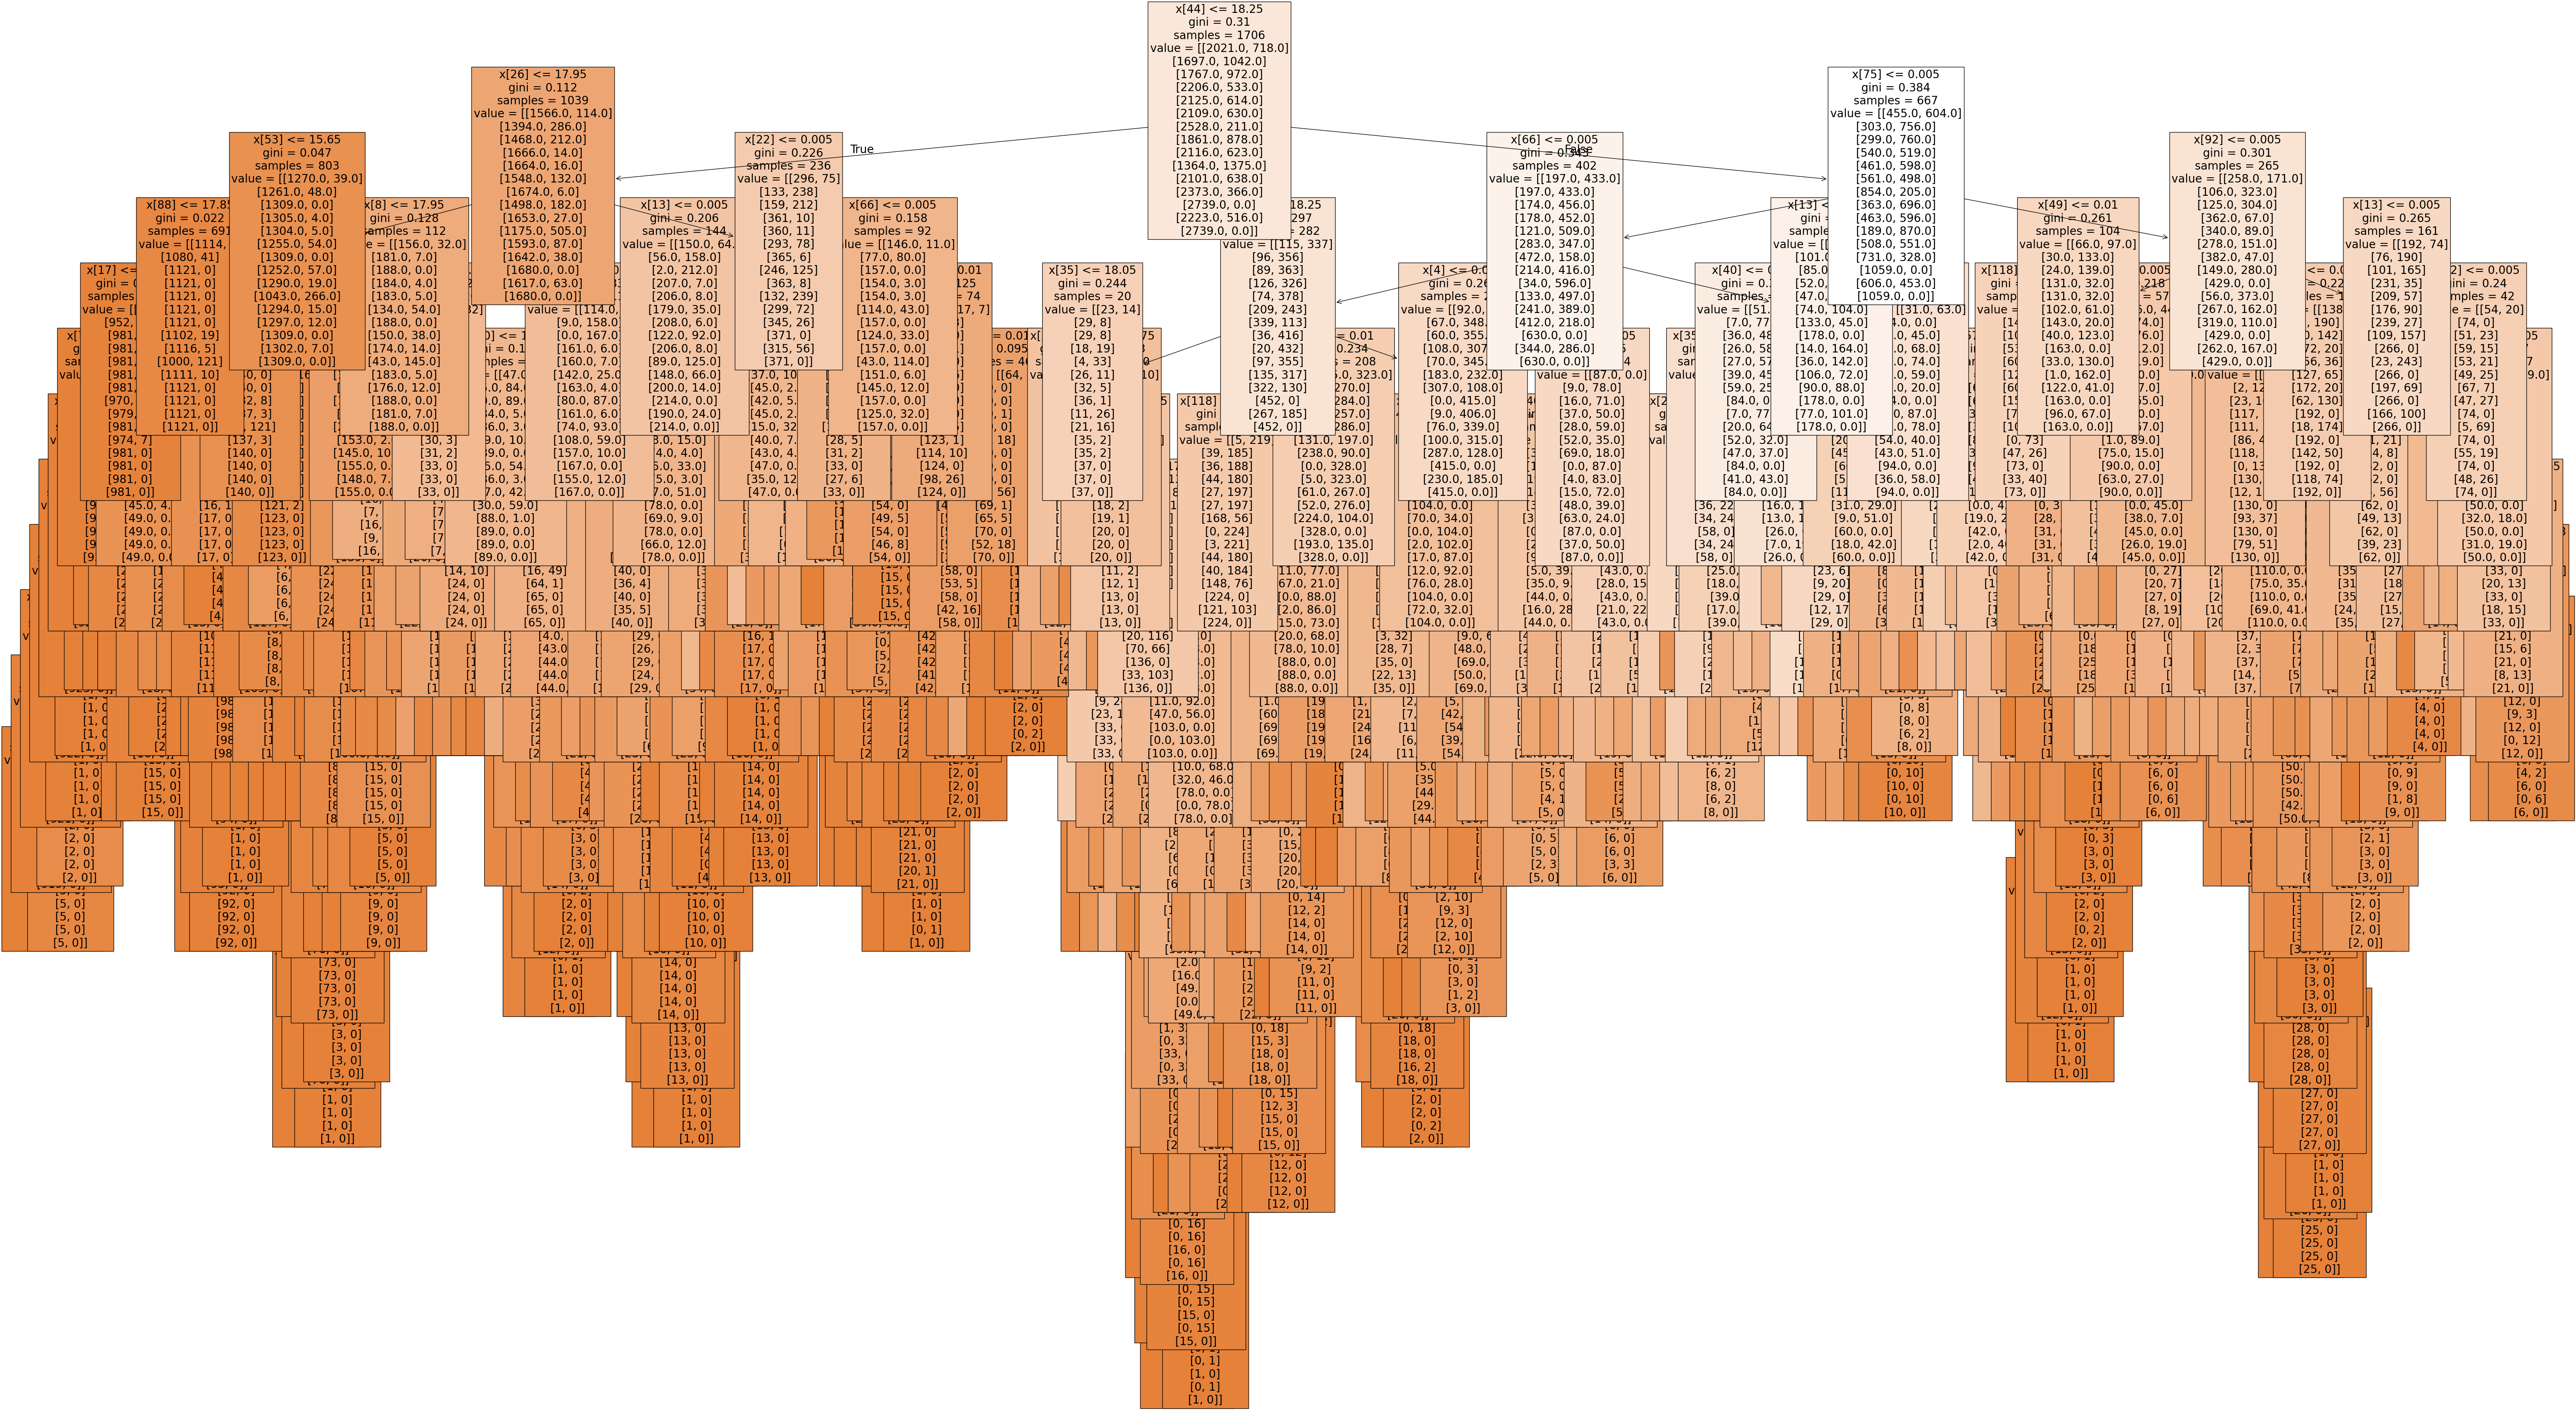

In [175]:
# Define class names for readability
class_names = ['Unpleasant Weather', 'Pleasant Weather']

# Plot the tree
fig = plt.figure(figsize=(80, 40))
plot_tree(clf3.estimators_[15], 
          filled=True, 
          fontsize=20,
          feature_names=None,  # You can add your feature names here if you'd like
          class_names=class_names);  # Adds class labels at the leaves

In [176]:
fig.savefig(os.path.join(path, 'optimized_random_forest_decade.png'),bbox_inches='tight')

### 8. FEATURE IMPORTANCE ANALYSIS

In [178]:
# Retrieve feature importances from the trained model

newarray = clf3.feature_importances_
print(clf3.feature_importances_.shape) # Should print: (135,)
newarray # This shows the raw importance values

(135,)


array([7.55120393e-04, 1.16839098e-03, 9.96132972e-04, 1.06975372e-03,
       3.29300311e-02, 2.65728770e-03, 3.12819726e-03, 7.30813146e-04,
       8.89834970e-02, 1.85322060e-03, 1.35445885e-03, 1.17262783e-03,
       8.61531486e-04, 3.11993795e-02, 1.05312952e-03, 2.89363523e-03,
       9.00151408e-04, 9.69630771e-03, 1.57183582e-04, 0.00000000e+00,
       0.00000000e+00, 4.54779711e-04, 3.03805711e-02, 4.54872208e-04,
       7.32774356e-03, 9.66718480e-04, 2.13283270e-02, 7.27104769e-04,
       7.61634265e-04, 1.15720614e-03, 1.26159685e-03, 1.61860621e-02,
       1.53414143e-03, 1.14962863e-03, 1.11017758e-03, 3.72015786e-02,
       4.49367849e-04, 7.75284236e-04, 8.67559204e-04, 1.10552668e-03,
       4.39217478e-02, 1.38285770e-03, 4.75362992e-03, 6.94413131e-04,
       1.60682091e-01, 9.33992748e-04, 2.19540561e-03, 9.83679936e-04,
       2.13962959e-03, 1.62527729e-02, 2.64638390e-03, 1.81774191e-03,
       9.94161101e-04, 9.12769375e-03, 9.10245509e-04, 7.67452211e-04,
      

In [179]:
# Reshape feature importances into (1, 15 stations, 9 features each)

newarray = newarray.reshape(-1, 15, 9)
print("Reshaped array shape:", newarray.shape)  # Should print: (1, 15, 9)

Reshaped array shape: (1, 15, 9)


In [180]:
# Sum across the 9 features for each station (collapse to one value per station)

sumarray = np.sum(newarray[0], axis=1)  # shape becomes (15,)

In [181]:
# Convert station set to a list and align it with importance values

stations_list = list(stations)

In [182]:
# Just in case station order is random in the set (to ensure consistency)

stations_list.sort()

In [183]:
# Create a sorted Series and DataFrame for plotting

important = pd.Series(sumarray, index=stations_list).sort_values(ascending=False)

df_importance = pd.DataFrame({
    'Weather Station': important.index,
    'Importance': important.values
})

Text(0.5, 1.0, 'Weather Station Importance — 2010s')

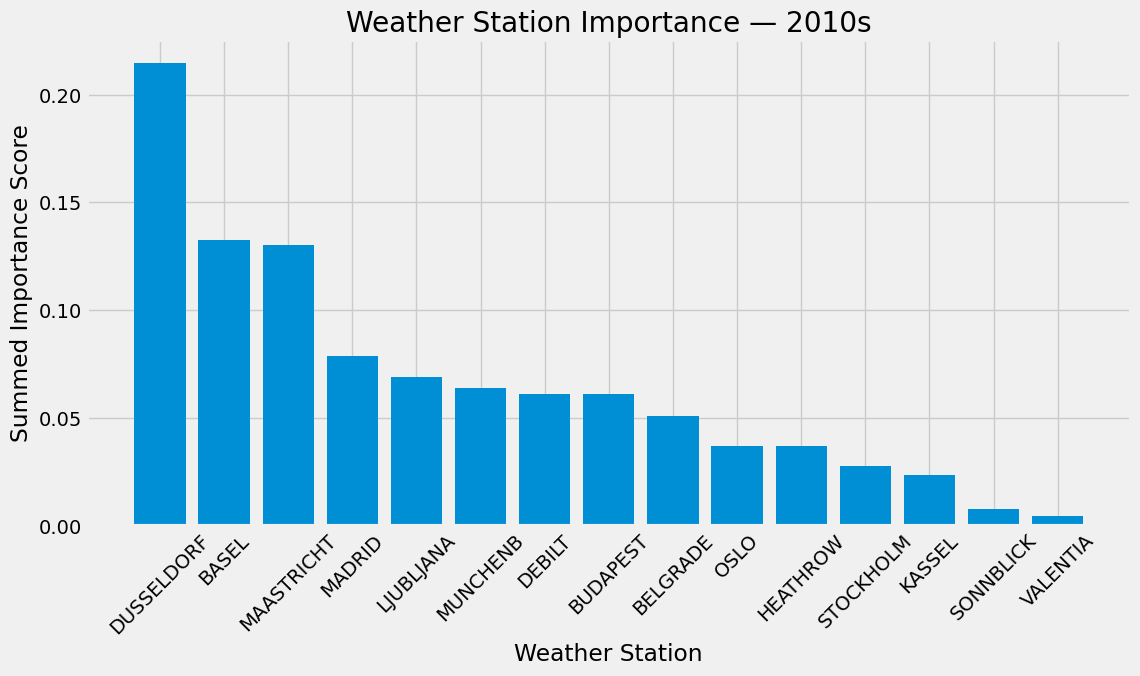

In [184]:
# Plotting

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))
plt.bar(df_importance['Weather Station'], df_importance['Importance'])
plt.xticks(rotation=45)
plt.xlabel('Weather Station')
plt.ylabel('Summed Importance Score')
plt.title('Weather Station Importance — 2010s')

In [185]:
# Get all columns that start with 'BASEL'
basel_columns = [col for col in data.columns if col.startswith('BASEL')]
print(basel_columns)

['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max']


In [186]:
fig.savefig(os.path.join(path, 'optimized_importance_decade.png'),bbox_inches='tight')

### 9. EVALUATION OF MODEL AND INSIGHTS

The test accuracy was 58,6 % when filtering data for one decade without optimization. The optimized data gave a model with 64,8 % accuracy.
When running the importance score Dusseldorf is still the city that mostly contributed to the models predictive power. After Dusseldorf, there was Basel, Maastricht and Madrid. The importance order changed as opposed to running with non-optimized hyperparameters (Dusseldorf, Maastricht, Munchen, Basel). 

Valentia contributed very little to the models predictions in both cases. However, all cities did contribute and the model still relies on all of them for the predictions. 


